# 1. 导入python库

In [1]:
import pandas as pd
import numpy as np
import os

%matplotlib inline
from matplotlib import pyplot as plt

from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

from sklearn.metrics import confusion_matrix, roc_curve, auc, recall_score, precision_score, f1_score


# 2. 参数设置

In [2]:
daily_back=20
wenben_back=10

wenben_sort=2

batch_size=32
epochs=200

LSTM_num=100
dense_num=20
learning_rate=0.001


mix_file='daily_data.xlsx'
first_columns='search_index'


total_day=2159 #根据查看数据表，得到数值
train_num=1295
test_num=total_day-train_num

# 3. 读取原始数据

In [3]:
new_dir='/Users/ccmac/Desktop/完成SCI数据'


daily_df=pd.read_excel(os.path.join(new_dir,mix_file))
fif_df=pd.read_excel(os.path.join(new_dir,'fif_data.xlsx'))
target_df=pd.read_excel(os.path.join(new_dir,'target.xlsx'))
wenben_df=pd.read_excel(os.path.join(new_dir,mix_file))

# 4. 标准化

## 4.1 历史数据标准化函数norm

In [4]:
def norm(df):
    x=df.copy()
    open_mean_value = df['open'].mean(axis=0)
    high_mean_value = df['high'].mean(axis=0)
    low_mean_value = df['low'].mean()
    close_mean_value = df['close'].mean()
    volumerate_mean_value = df['volume_rate'].mean()

    open_std_value = df['open'].std()
    high_std_value = df['high'].std()
    low_std_value = df['low'].std()
    close_std_value = df['close'].std()
    volumerate_std_value = df['volume_rate'].std()

    x['open']=(df['open']-open_mean_value)/open_std_value
    x['high'] = (df['high'] - high_mean_value) / high_std_value
    x['low'] =  (df['low'] - low_mean_value) / low_std_value
    x['close'] =  (df['close'] - close_mean_value) / close_std_value
    x['volume_rate'] = (df['volume_rate'] - volumerate_mean_value) / volumerate_std_value
    df=x
    return df

## 4.2 文本数据标准化函数wenben_norm

In [5]:
def wenben_norm(df):
    x=df.copy()
    sector_score_mean_value = df['sector_score'].mean(axis=0)
    search_index_mean_value = df['search_index'].mean(axis=0)

    sector_score_std_value = df['sector_score'].std()
    search_index_std_value = df['search_index'].std()

    x['sector_score']=(df['sector_score']-sector_score_mean_value)/sector_score_std_value
    x['search_index'] = (df['search_index'] - search_index_mean_value) / search_index_std_value
    
    df=x
    
    return df

# 5. 数据切分训练集与测试集

## 5.1 数据切分函数

In [6]:
def split_data(train_num=train_num,wenben_back=wenben_back):
    
    # 先切分
    daily_train_df=daily_df.loc[daily_df.index<train_num]
    daily_test_df=daily_df.loc[daily_df.index>=train_num]
    
    fif_train_df=fif_df.loc[fif_df.index<16*train_num]
    fif_test_df=fif_df.loc[fif_df.index>=16*train_num]
    
    wenben_train_df=wenben_df.loc[wenben_df.index<train_num]
    wenben_test_df=wenben_df.loc[wenben_df.index>=train_num]

    target_train_df=target_df.loc[target_df.index<train_num]
    target_test_df=target_df.loc[target_df.index>=train_num]

    
    #再进行归一化
    daily_train_df=norm(daily_train_df)
    daily_test_df=norm(daily_test_df)
    fif_train_df=norm(fif_train_df)
    fif_test_df=norm(fif_test_df)
    wenben_train_df=wenben_norm(wenben_train_df)
    wenben_test_df = wenben_norm(wenben_test_df)


    return {'daily_train_df':daily_train_df,
            'daily_test_df':daily_test_df,
            'fif_train_df':fif_train_df,
            'fif_test_df':fif_test_df,
            'target_train_df':target_train_df,
            'target_test_df':target_test_df,
            'wenben_train_df':wenben_train_df,
            'wenben_test_df': wenben_test_df
            }

## 5.2 进行数据切分

In [7]:
daily_norm_train_df=split_data()['daily_train_df']
print('日频训练切分：',daily_norm_train_df.shape)
daily_norm_test_df=split_data()['daily_test_df']
print('日频测试切分：',daily_norm_test_df.shape)
fif_norm_train_df=split_data()['fif_train_df']
print('十五分钟频训练切分：',fif_norm_train_df.shape)
fif_norm_test_df=split_data()['fif_test_df']
print('十五分钟频测试切分：',fif_norm_test_df.shape)
target_norm_train_df=split_data()['target_train_df']
print('训练目标切分：',target_norm_train_df.shape)
target_norm_test_df=split_data()['target_test_df']
print('测试目标切分：',target_norm_test_df.shape)
wenben_norm_train_df=split_data()['wenben_train_df']
wenben_norm_test_df=split_data()['wenben_test_df']

日频训练切分： (1295, 8)
日频测试切分： (864, 8)
十五分钟频训练切分： (20720, 6)
十五分钟频测试切分： (14000, 6)
训练目标切分： (1295, 2)
测试目标切分： (875, 2)


# 6. 数据转化为神经网络输入格式

## 6.1 建立转化类（返回多个字典）

In [8]:
class Data_maker:
    def __init__(self,train_num,test_num,fif_back,daily_back,wenben_back):
        self.train_num=train_num
        self.test_num=test_num
        self.fif_back=fif_back
        self.daily_back=daily_back
        self.wenben_back = wenben_back


    def daily_train_data(self,data):
        while True:
            rows = list(range(self.train_num - self.daily_back)) #总共1650个数据，由于扣除前面20个数据，所以为1630
            ### 先构造空（预测日长度*日后移）array
            samples = np.zeros((len(rows),
                                 self.daily_back,
                                 5))
            print(samples.shape)
            for j in rows:
                ### 每一个填入用于预测一天的开盘价到波动率矩阵
                samples[j] = data.loc[
                                  (data.index >= j) & (data.index < self.daily_back + j),
                                  'open':'volume_rate']
            print(data.index)
            print('日频训练array：',samples.shape)
            return samples
    def fif_train_data(self,data):
        while True:
            rows = list(range(self.train_num - self.daily_back))
            samples = np.zeros((len(rows),
                                 self.fif_back,
                                 5))
            for j in rows:

                samples[j] = data.loc[
                              (data.index >= j * self.fif_back ) & (data.index < (j+1) * self.fif_back),
                              'open':]
            print('十五分钟训练array：',samples.shape)
            return samples
    def wenben_train_data(self,data):
        while True:
            rows = list(range(self.train_num - self.daily_back)) #总共1489个数据，由于扣除前面20个数据，所以为1469
            samples = np.zeros((len(rows),
                                 self.wenben_back,
                                 wenben_sort))
            for j in rows:

                samples[j] = data.loc[
                                  (data.index >= j) & (data.index < self.wenben_back + j),
                                  first_columns:]
            print('文本长期训练array：',samples.shape)
            return samples
   

    def daily_test_data(self,data):
        while True:
            rows = list(range(self.test_num - self.daily_back))
            print(self.test_num,self.daily_back)
            print(rows)
            samples = np.zeros((len(rows),
                                self.daily_back,
                                 5))
            for j in rows:


                samples[j] = data.loc[
                                  (data.index >= self.train_num+j) & (data.index < self.train_num+self.daily_back + j),
                                  'open':'volume_rate']
            print('日测试array：',samples.shape)
            print('试一试index', data.index,'train_num',self.train_num)
            return samples

    def wenben_test_data(self, data):
        while True:
            rows = list(range(self.test_num - self.daily_back))
            samples = np.zeros((len(rows),
                                self.wenben_back,
                                wenben_sort))
            for j in rows:
                samples[j] = data.loc[
                             (data.index >= self.train_num + j) & (data.index < self.train_num + self.wenben_back + j),
                             first_columns:]
            print('长期文本测试array：', samples.shape)
            return samples
   
    def fif_test_data(self,data):
        while True:
            rows = list(range(self.test_num - self.daily_back))
            samples = np.zeros((len(rows),
                                self.fif_back,
                                 5))
            for j in rows:


                samples[j] = data.loc[
                                 (data.index >= 16*self.train_num+(j) * self.fif_back) & (data.index < 16*self.train_num+(j+1) * self.fif_back),
                                 'open':]
            print('十五分钟测试array：',samples.shape)
            return samples
    def target_train_data(self,data):
        while True:
            rows = list(range(self.train_num-self.daily_back))
            targets = np.zeros((len(rows),))
            for j in rows:


                targets[j] = data.loc[data.index == j, 'target'].iloc[0] #根据提示，添加了.iloc[0]
            print('训练标签array',targets.shape)
            return targets
    def target_test_data(self,data):
        while True:
            rows = list(range(self.test_num-self.daily_back))
            targets = np.zeros((len(rows),))
            for j in rows:


                targets[j] = data.loc[data.index == self.train_num+j, 'target'].iloc[0] ##出问题：应该是。而不是***：data.index == self.train_num+j
            print(targets.shape)
            return targets

## 6.2 设置类方法里的参数，赋值给origin_data_maker，仍然是一个class类

In [9]:
origin_data_maker=Data_maker(train_num=train_num,test_num=test_num,fif_back=16,daily_back=daily_back,wenben_back=wenben_back)

# 6.3 调用类中的方法,处理原始数据

In [10]:
DM = origin_data_maker

daily_train_prepared = DM.daily_train_data(daily_norm_train_df)
daily_test_prepared = DM.daily_test_data(daily_norm_test_df)

fif_train_prepared = DM.fif_train_data(fif_norm_train_df)
fif_test_prepared = DM.fif_test_data(fif_norm_test_df)

wenben_train_prepared = DM.wenben_train_data(wenben_norm_train_df)
wenben_test_prepared = DM.wenben_test_data(wenben_norm_test_df)

target_train_prepared = DM.target_train_data(target_norm_train_df)
target_test_prepared = DM.target_test_data(target_norm_test_df)


(1275, 20, 5)
Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
       ...
       1285, 1286, 1287, 1288, 1289, 1290, 1291, 1292, 1293, 1294],
      dtype='int64', length=1295)
日频训练array： (1275, 20, 5)
864 20
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176

In [11]:
# daily_train_prepared
# daily_test_prepared

# fif_train_prepared
# fif_test_prepared 

# wenben_train_prepared
# wenben_test_prepared

# target_train_prepared
# target_test_prepared

# 7. 神经网络模型训练

## 7.1 模型建立 

In [12]:
def my_model(daily_back):

    ##### 一、模型搭建



    # 15分钟频输入训练(!!!卷积滤镜行列先后)
    fif_min_input=Input(shape=(16,5),dtype='float32',name='fif_min_input')
    # fif_min_input=(8,16,4,1)
    Conv1D_fif=layers.Conv1D(16,1,strides=1)(fif_min_input)
    LSTM_fif=layers.LSTM(LSTM_num)(Conv1D_fif)

    # 日频输入训练
    daily_input=Input(shape=(daily_back,5),dtype='float32',name='daily_input')
    # daily_input=(8,16,4,1)
    Conv1D_daily=layers.Conv1D(16,1,strides=1)(daily_input)
    LSTM_daily=layers.LSTM(LSTM_num)(Conv1D_daily)
    # 15分钟频训练结果和日频训练结果合并
    concatenated=layers.concatenate([LSTM_fif,LSTM_daily],axis=-1) # axis=-1按照最后一个轴粘合

    alloy=layers.Dense(dense_num,activation='relu')(concatenated) #将粘合结果再接一个全连接层
    dropout=layers.Dropout(0.2)(alloy)
    output=layers.Dense(1,activation='sigmoid')(dropout)
    model=Model([fif_min_input,daily_input],output) #八股文：将输入和输出圈起来

    print(model.summary())
    model.compile(optimizer=Adam(learning_rate=learning_rate),loss='binary_crossentropy',metrics=['acc'])
    return model
    # reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, mode='auto')


## 7.2 模型滞后时长赋值

In [13]:
model=my_model(daily_back=daily_back)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ fif_min_input       │ (None, 16, 5)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ daily_input         │ (None, 20, 5)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 16, 16)    │         96 │ fif_min_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 20, 16)    │         96 │ daily_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 100)       │     46,800 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 100)       │     46,800 │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 200)       │          0 │ lstm[0][0],       │
│ (Concatenate)       │                   │            │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 20)        │      4,020 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 20)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │         21 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 97,833 (382.16 KB)

 Trainable params: 97,833 (382.16 KB)

 Non-trainable params: 0 (0.00 B)

None


## 7.3 添加输出模型参数的代码块

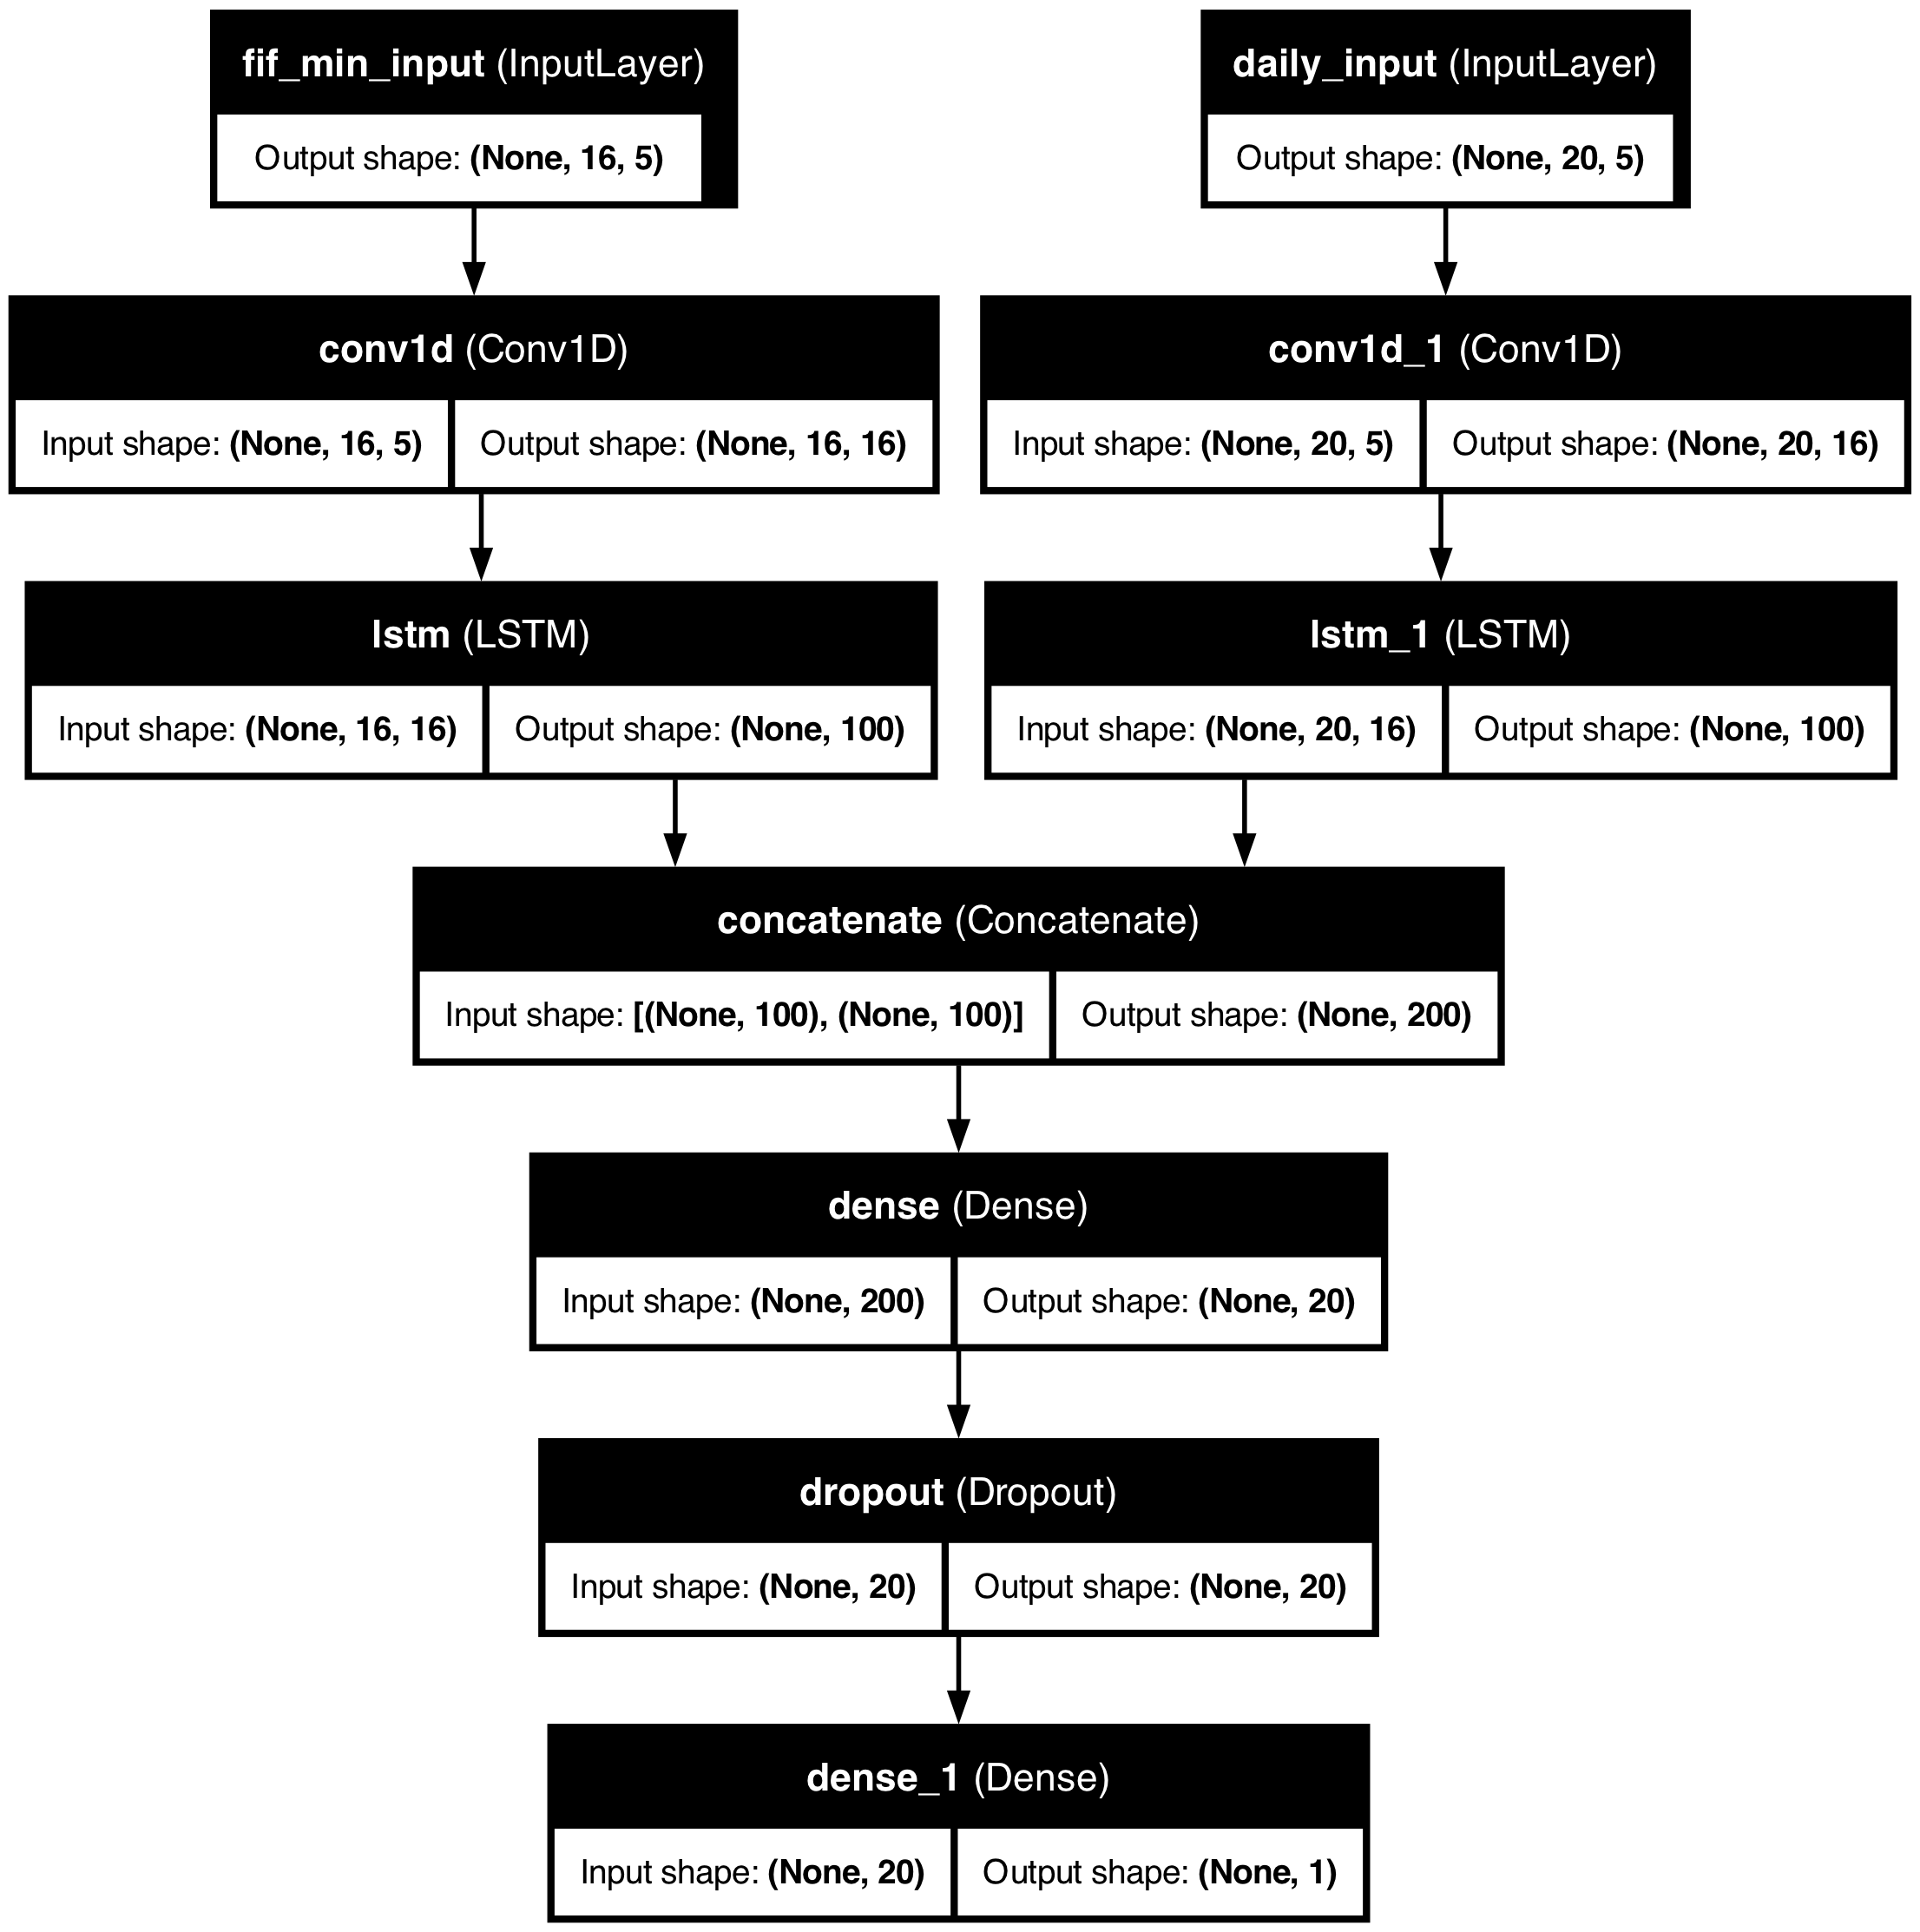

In [14]:
plot_model(model, to_file='model_structure.png', show_shapes=True, show_layer_names=True)

## 7.4 model.fit(输入训练数据x，标志y)

In [15]:
history = model.fit(x=[fif_train_prepared,daily_train_prepared],y=target_train_prepared,batch_size=batch_size,validation_split=0.25,epochs=epochs)


Epoch 1/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - acc: 0.5270 - loss: 0.6991 - val_acc: 0.5455 - val_loss: 0.7231
Epoch 2/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - acc: 0.5873 - loss: 0.6873 - val_acc: 0.5423 - val_loss: 0.7011
Epoch 3/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - acc: 0.5634 - loss: 0.6871 - val_acc: 0.5423 - val_loss: 0.7028
Epoch 4/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - acc: 0.5766 - loss: 0.6780 - val_acc: 0.5423 - val_loss: 0.6976
Epoch 5/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - acc: 0.5907 - loss: 0.6767 - val_acc: 0.5423 - val_loss: 0.7121
Epoch 6/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - acc: 0.5388 - loss: 0.6901 - val_acc: 0.5329 - val_loss: 0.7181
Epoch 7/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - acc: 0.5245 - loss: 0.6823 - val_acc: 0.5580 - val_loss: 0.7020
Epoch 8/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - acc: 0.5774 - loss: 0.6768 - val_acc: 0.5392 - val_loss: 0.7248
Epoch 9/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - ac

## 7.5 model.evaluate(输入测试数据)，进行模型预测性能测试

In [16]:
loss,accuracy = model.evaluate([fif_test_prepared,daily_test_prepared],y=target_test_prepared)
print(loss,accuracy)

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.5965 - loss: 2.7016 
2.243842363357544 0.6350710988044739


# 8. 回测

# 构建y的函数

In [17]:
def gen_y_pred():
    y_predict=model.predict([fif_test_prepared,daily_test_prepared],batch_size=1).reshape(test_num-daily_back).tolist() ###batch_size要设为1，不然evaluate和predict结果不同
    y_pred=[]
    for i,v in enumerate(y_predict):
        if v>0.5:
            y_pred.append(1)
        if v<0.5:
            y_pred.append(0)
    return y_pred

# 制作y

In [18]:
y_pred=gen_y_pred()
print(y_pred)

844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
[0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

#  构建使用测试集作为回测数据的类

In [19]:
class Back_tes_trader:
    def __init__(self,train_num,daily_back):
        self.train_num=train_num
        self.daily_back=daily_back
    def daily_test_data(self,data):
        while True:
            samples = data.loc[
                data.index >=self.train_num+self.daily_back ,
                ['open','close']]
            print(data.index)
            return samples
        


# 回测数据集代入参数，形成回撤数据back_tes_trader

In [20]:
back_tes_trader=Back_tes_trader(train_num=train_num,daily_back=daily_back)

In [21]:
def split_back_trader(train_num=train_num):

    daily_test_df=daily_df.loc[daily_df.index>=train_num]

    return {'daily_test_df':daily_test_df}

In [22]:
back_df=split_back_trader()['daily_test_df']

In [23]:
back_df

,trade_time,open,high,low,close,volume_rate,search_index,sector_score
1295,2021-04-29,3458.08,3478.23,3447.59,3474.90,276631387,191388,0.600995
1296,2021-04-30,3468.30,3469.09,3426.90,3446.86,312660354,187570,0.588500
1297,2021-05-06,3446.07,3471.24,3426.85,3441.28,310424192,205453,0.562318
1298,2021-05-07,3446.41,3457.89,3416.78,3418.87,353785389,205685,0.460457
1299,2021-05-10,3423.59,3429.74,3401.93,3427.99,374170884,182035,0.479976
...,...,...,...,...,...,...,...,...
2154,2024-12-02,3328.48,3369.30,3323.01,3363.98,668477762,428407,-0.647137
2155,2024-12-03,3366.29,3386.62,3348.37,3378.81,663030139,438283,-0.861024
2156,2024-12-04,3376.57,3388.02,3352.94,3364.65,621028862,425902,-0.984183
2157,2024-12-05,3353.06,3377.06,3353.06,3368.86,543885746,397751,-0.812990


In [24]:
backtrader_df=back_tes_trader.daily_test_data(back_df)

Index([1295, 1296, 1297, 1298, 1299, 1300, 1301, 1302, 1303, 1304,
       ...
       2149, 2150, 2151, 2152, 2153, 2154, 2155, 2156, 2157, 2158],
      dtype='int64', length=864)


# 形成day_rate_of_return日内收益率，和rate_of_return隔夜收益率

In [25]:
backtrader_df['rate_of_return'] = backtrader_df['close'].rolling(2).apply(lambda x: x[1] / x[0] - 1, raw=True)
backtrader_df['day_rate_of_return']=backtrader_df['close']/backtrader_df['open']-1

clo_1=backtrader_df.loc[(backtrader_df.index<total_day-1),"close"].tolist()

print(len(clo_1))
print(backtrader_df.loc[(backtrader_df.index>=train_num+daily_back+1),:])
backtrader_df.loc[(backtrader_df.index>=train_num+daily_back+1),'last_close']=clo_1
backtrader_df['sale_rate_of_return']=backtrader_df['open']/backtrader_df['last_close']-1


print(backtrader_df)
print(backtrader_df.shape)
trade_day_return_list=[]
return_list=[]
every_day_return_list=[]

843
         open    close  rate_of_return  day_rate_of_return
1316  3626.33  3597.14       -0.007606           -0.008049
1317  3595.42  3584.21       -0.003595           -0.003118
1318  3565.47  3591.84        0.002129            0.007396
1319  3597.14  3599.54        0.002144            0.000667
1320  3598.75  3580.11       -0.005398           -0.005180
...       ...      ...             ...                 ...
2154  3328.48  3363.98        0.011279            0.010666
2155  3366.29  3378.81        0.004408            0.003719
2156  3376.57  3364.65       -0.004191           -0.003530
2157  3353.06  3368.86        0.001251            0.004712
2158  3370.94  3404.08        0.010455            0.009831

[843 rows x 4 columns]
         open    close  rate_of_return  day_rate_of_return  last_close  \
1315  3608.60  3624.71             NaN            0.004464         NaN   
1316  3626.33  3597.14       -0.007606           -0.008049     3624.71   
1317  3595.42  3584.21       -0.003595    

# 回测交易逻辑

In [26]:
def backtrader(list,df):
    a=0

    rate_of_return = 1
    for i,v in enumerate(list):
        if (v ==1)&(a==0):
            b=(1 + df.loc[train_num+daily_back + i, 'day_rate_of_return'])
            rate_of_return= rate_of_return * b
            a=1
            trade_day_return_list.append(b-1)
            return_list.append(rate_of_return)
            every_day_return_list.append(b - 1)

        elif (v ==1)&(a==1):
            b=(1 + df.loc[train_num+daily_back + i, 'rate_of_return'])
            rate_of_return= rate_of_return *b
            a=a
            trade_day_return_list.append(b-1)
            return_list.append(rate_of_return)
            every_day_return_list.append(b - 1)
        elif (v==0)&(a==0):
            rate_of_return=rate_of_return
            a=a
            every_day_return_list.append(0)

        elif (v==0)&(a==1):
            a=0
            b = (1 + df.loc[train_num+daily_back + i, 'sale_rate_of_return'])
            rate_of_return=rate_of_return*b
            trade_day_return_list.append(b-1)
            every_day_return_list.append(b - 1)
            return_list.append(rate_of_return)
    return a,trade_day_return_list,rate_of_return,return_list,every_day_return_list

In [27]:
result=backtrader(y_pred,backtrader_df)
# print(result[1])
# print(result[2])
# print(result[3])
pingjun_nian_jiaoyi_ri=240*len(result[1])/(len(y_pred))
sharp=(np.mean(result[1]))/(np.std(result[1],ddof=1))*np.sqrt(pingjun_nian_jiaoyi_ri)
# sharp1=(np.mean(result[4]))/(np.std(result[4]))
# print('夏普比率--：',sharp1)
print('夏普比率：',sharp)
print('收益率：',result[2]-1)


夏普比率： 0.08909415117476023
收益率： 0.012177008501306208


In [28]:
returns=result[3]
returns = [ret - 1 for ret in returns]
# returns

In [29]:
returns=result[3]
returns = [ret - 1 for ret in returns]

# 将收益率列表转换为pandas的Series对象，方便处理
returns_series = pd.Series(returns)

# 计算累计收益率
cumulative_returns = (1 + returns_series).cumprod() - 1

# 计算滚动最大值
rolling_max = cumulative_returns.cummax()

# 计算回撤
drawdown = cumulative_returns - rolling_max

# 计算最大回撤
max_drawdown = drawdown.min()

# 打印最大回撤
print("最大回撤: {:.2%}".format(max_drawdown))


最大回撤: -99.20%


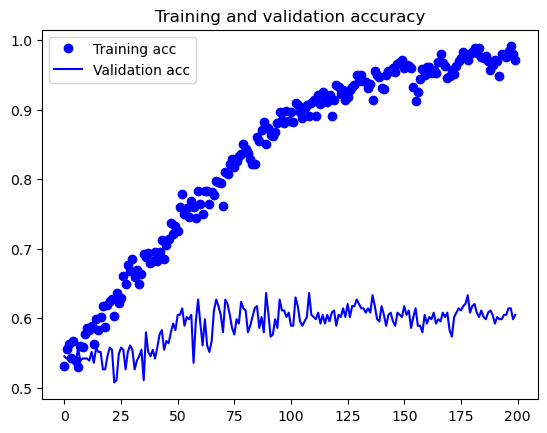

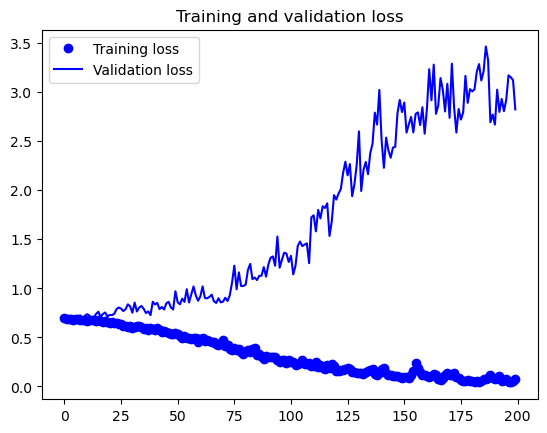

In [30]:
def paint():
    acc=history.history['acc']
    val_acc=history.history['val_acc']
    loss=history.history['loss']
    val_loss=history.history['val_loss']

    epochs=range(len(acc))
    plt.plot(epochs,acc,'bo',label='Training acc')
    plt.plot(epochs,val_acc,'b',label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs,loss,'bo',label='Training loss')
    plt.plot(epochs,val_loss,'b',label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    return plt
my_paint=paint()
my_paint.show()

# 混淆矩阵绘制

In [31]:
confusion_matrix = confusion_matrix(target_test_prepared, y_pred,labels=[1,0])
precision_score=precision_score(target_test_prepared, y_pred)
recall_score=recall_score(target_test_prepared, y_pred)
f1_score=f1_score(target_test_prepared, y_pred)

print('混淆矩阵：',confusion_matrix)
print('查准率：',precision_score)
print('查全率：',recall_score)
print('f1-score:',f1_score)

混淆矩阵： [[295 125]
 [183 241]]
查准率： 0.6171548117154811
查全率： 0.7023809523809523
f1-score: 0.6570155902004454


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


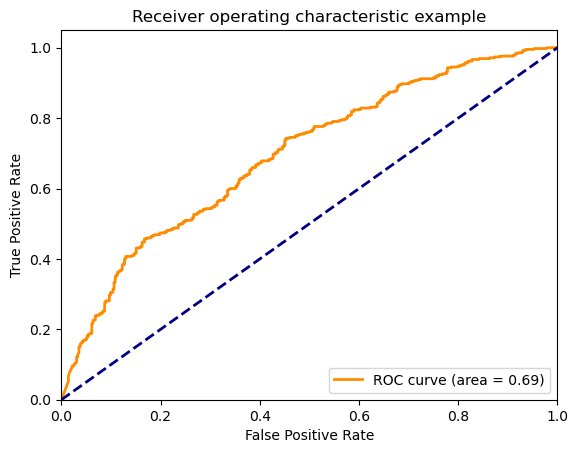

In [32]:
y_predict=model.predict([fif_test_prepared,daily_test_prepared]).reshape(test_num-daily_back).tolist()
fpr,tpr,threshold = roc_curve(target_test_prepared, y_predict) ###计算真正率和假正率
# print(fpr,tpr,threshold)
roc_auc = auc(fpr,tpr)


lw = 2
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率为横坐标，真正率为纵坐标做曲线
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# 保存

In [33]:
# df9=pd.DataFrame({'损失值':loss,'准确率':accuracy,'夏普值':sharp,'收益率':result[2]-1,'最大回撤':[max_drawdown],'查准率':[precision_score],'查全率':[recall_score],'f1-score':[f1_score]})
# df10=pd.DataFrame({'每日收益率':result[1]})
# path9='/Users/ccmac/Desktop'
# df9.to_excel(os.path.join(path9,'数据表.xlsx'),index=False)
# df10.to_excel(os.path.join(path9,'每日收益率表.xlsx'),index=False)

In [34]:
# import numpy as np
# t = np.array([1, 2, 3, 4, 5, 6, 7, 8]).reshape([2,4])
# y = np.cumprod(t, axis=1)
# print(t)
# print(y)
